# Прогнозирование заказов такси

**Цель проекта:** Построить модель, которая  будет предсказывать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. 
* Для обучения и тестирования модели представлены исторические данные компании "Чётенькое такси" о заказах такси в аэропортах.
* Значение метрики RMSE на тестовой выборке должно быть не больше 48.


**План проекта**:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt 

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Подготовка данных

In [3]:
#загрузка данных
data=pd.read_csv("E:\\taxi.csv",parse_dates=[0],index_col=[0])

In [4]:
#первые строки таблицы
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


* Таблица содержит информацию о количестве заказов такси за каждые 10 минут.

In [5]:
#общая информация о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
#проверка на пропуски
data.isna().sum()

num_orders    0
dtype: int64

* Пропуски в данных отсутствуют.

In [7]:
#проверка, что индекс монотонный
data.index.is_monotonic

True

* Индекс монотонный, то есть даты стоят в верном порядке (по возрастанию).

**Задача проекта - предсказать количество заказов на следующий час, поэтому нужно выполнить ресемплирование по одному часу, дальнейшую работу проводить с суммой заказов за каждый час.**

In [8]:
#ресемплирование по одному часу
data=data.resample('1H').sum()

## Анализ данных

In [9]:
#какой период времени дан для анализа
print(data.index.min(),data.index.max())

2018-03-01 00:00:00 2018-08-31 23:00:00


* Для анализа представлены данные в период с 1 марта по 31 августа 2018 года (6 месяцев, полгода). Поэтому анализ сезонности невозможен для данных.

In [10]:
# расклад временного ряда на три составляющие: тренд, сезонность и остаток 
decomposed=seasonal_decompose(data)

<AxesSubplot:xlabel='datetime'>

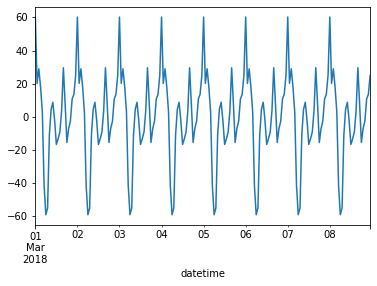

In [11]:
#график сезонности для одной недели
decomposed.seasonal['2018-03-01':'2018-03-08'].plot()

* Из графика было подтверждено, что для представленных данных сезонность отсутствует.

<AxesSubplot:xlabel='datetime'>

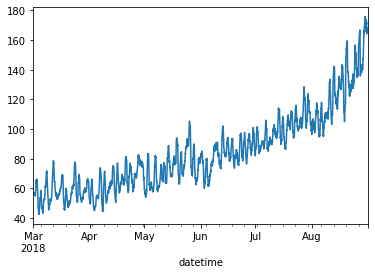

In [12]:
#график тренда
decomposed.trend.plot()

* Исходя из полученного графика видно, что в период с марта по август суммарное количество заказов такси за час растет.

<AxesSubplot:>

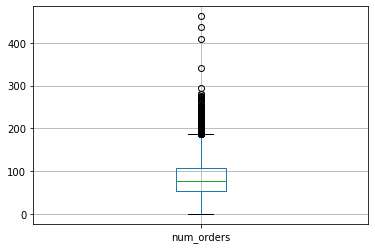

In [13]:
#анализ выбросов в данных
data.boxplot()

* Для анализа представлены значения количества заказов такси за час в аэропортах. Минимальное кол-во - 0 , максимальное более 400, что вполне реально (напрмер: прилет более 2-ух самолетов приблизительно в одно и то же время) , поэтому оставим данные без изменений.

**Для дальнейшего обучения модели нужно создать признаки**

In [14]:
#функция для создания отстающих признаков и признака скользящего среднего
def features(data,lag,window):
    data_new = data.copy()
#создание календарных и временных признаков
#месяц 
    data_new['month']=data.index.month
#день недели
    data_new['dayofweek']=data.index.dayofweek
#время(час)
    data_new['hour']=data.index.hour
    
#отстающие признаки (lag- число лагов(отставаний))
    for l in range(1,lag+1):
        data_new['lag_{}'.format(l)]=data['num_orders'].shift(l)
        
#признак скользящего среднего(window-кол-во окон)
    data_new['rolling_mean']=data['num_orders'].rolling(window).mean()
    data_new=data_new.dropna()
    return data_new

In [15]:
#создадим 3 набора данных с разными параметрами числа лагов и количества окон
data1=features(data,5,10)
data2=features(data,12,17)
data3=features(data,15,18)

## Обучение

**Целевым признаком для данного проекта является кол-во заказов - 'num_orders' . Из условия тестовую выборку равна 10% от исходных данных.**

In [16]:
#функция для деления на тренировочную, тестовую выборки и для выделения целевого признака и признаков
def data_for_model(data):
#разделим данные на тренирвочную и тecтовую выборки
    train,test=train_test_split(data,test_size=0.1,shuffle=False)
#разделим на целевой признак и признаки
    train_target=train['num_orders']
    train_features=train.drop('num_orders',axis=1)
#для тестовой выборки
    test_target=test['num_orders']
    test_features=test.drop('num_orders',axis=1)
    return train_target,train_features,test_target,test_features

In [17]:
#выборки для 1-го набора данных
train_target1,train_features1,test_target1,test_features1=data_for_model(data1)

In [18]:
#выборки для 2-го набора данных
train_target2,train_features2,test_target2,test_features2=data_for_model(data2)

In [19]:
#выборки для 3-го набора данных
train_target3,train_features3,test_target3,test_features3=data_for_model(data3)

**Линейная регрессия**

In [20]:
#обучение и предсказание линейной регрессии для 1-го набора данных
lin_model_1=LinearRegression()
lin_model_1.fit(train_features1,train_target1)
lin_predictions_1=lin_model_1.predict(test_features1)

In [21]:
#обучение и предсказание линейной регрессии для 2-го набора данных
lin_model_2=LinearRegression()
lin_model_2.fit(train_features2,train_target2)
lin_predictions_2=lin_model_2.predict(test_features2)

In [22]:
#обучение и предсказание линейной регрессии для 3-го набора данных
lin_model_3=LinearRegression()
lin_model_3.fit(train_features3,train_target3)
lin_predictions_3=lin_model_3.predict(test_features3)

**Случайный лес**

In [23]:
#функция кросс-валидации для случайного дерева
def cross_valid_forest(data,k):    
    #кросс-валидация проводится только на тренировочной выборке
    train,test=train_test_split(data,test_size=0.1,shuffle=False)
    
    #для кросс-валидации временных рядов используется объект TimeSeriesSplit с 5 выборками
    tscv = TimeSeriesSplit(n_splits=5)
    
    target=train['num_orders'].copy()
    features=train.drop('num_orders',axis=1).copy()
    
    #перебор параметров глубины деревьев
    max_depth=[10,20,30,40,50,60,70]
    scores = []
    metrics=[]
    depth=[]
    mean=0
    print('Среднее значение метрики RMSE для {} набора данных'.format(k))
    for i in max_depth:
        depth.append(i)
        print('при глубине равной', i)
        a=mean
        for tr_index, val_index in tscv.split(features):
        
            data_train_features, data_valid_features = features.iloc[tr_index], features.iloc[val_index]
            data_train_target, data_valid_target = target.iloc[tr_index], target.iloc[val_index]
            model=RandomForestRegressor(random_state=1234,max_depth=i)
            model.fit(data_train_features,data_train_target)
            predictions=model.predict(data_valid_features)
            score=(mean_squared_error(data_valid_target,predictions))**0.5
            scores.append(score)
       #среднее значение метрики для 5 выборок
            mean=sum(scores)/5
        metrics.append(mean-a)
        print(mean-a)
    k=depth[metrics.index(min(metrics))]
    print('Минимальное значение метрики = ',min(metrics),'было достигнуто при глубине = ',k)

In [24]:
cross_valid_forest(data1,1)

Среднее значение метрики RMSE для 1 набора данных
при глубине равной 10
23.64800136307364
при глубине равной 20
23.45242118997954
при глубине равной 30
23.44668173839804
при глубине равной 40
23.44908969103946
при глубине равной 50
23.449089691039504
при глубине равной 60
23.44908969103949
при глубине равной 70
23.44908969103949
Минимальное значение метрики =  23.44668173839804 было достигнуто при глубине =  30


In [25]:
cross_valid_forest(data2,2)

Среднее значение метрики RMSE для 2 набора данных
при глубине равной 10
24.612060592972092
при глубине равной 20
24.38542787176381
при глубине равной 30
24.378412239239175
при глубине равной 40
24.376912196583262
при глубине равной 50
24.376912196583234
при глубине равной 60
24.37691219658322
при глубине равной 70
24.37691219658322
Минимальное значение метрики =  24.37691219658322 было достигнуто при глубине =  60


In [26]:
cross_valid_forest(data3,3)

Среднее значение метрики RMSE для 3 набора данных
при глубине равной 10
24.74655035338582
при глубине равной 20
24.47837402630475
при глубине равной 30
24.482095746310243
при глубине равной 40
24.479461281181372
при глубине равной 50
24.479461281181386
при глубине равной 60
24.479461281181358
при глубине равной 70
24.479461281181386
Минимальное значение метрики =  24.47837402630475 было достигнуто при глубине =  20


* Минимальное  среднее значение RMSE = 24.5 для модели случайного  леса было достигнуто при глубине = 20  для 1-го набора данных.

In [27]:
# обучение и предсказание наилучшей модели случайного леса
forest_model=RandomForestRegressor(random_state=12345,max_depth=20)
forest_model.fit(train_features1,train_target1)
forest_prediction=forest_model.predict(test_features1)

**Градиентный бустинг при помощи библиотеки CatBoostRegressor**

In [28]:
#функция для подбора параметром методом кросс-валидации для CatBoostRegressor
def catboost(data,k):
    print('Среднее значение метрики RMSE для {} набора данных'.format(k))
    #для кросс-валидации временных рядов используется объект TimeSeriesSplit с 5 выборками
    tscv = TimeSeriesSplit(n_splits=5)
    
    #кросс-валидация проводится только на тренировочной выборке
    train,test=train_test_split(data,test_size=0.1,shuffle=False)

    target=train['num_orders'].copy()
    features=train.drop('num_orders',axis=1).copy()
    
    #перебор параметров максимального количества деревьев
    iterations=[150,200,250,300,350]
    metrics=[]
    iter=[]
    scores = []
    mean=0
    
    for k in iterations:
        iter.append(k)
        print('iterations = ',k)
        a=mean
        for tr_index, val_index in tscv.split(features):
        
            train_features, valid_features = features.iloc[tr_index], features.iloc[val_index]
            train_target, valid_target = target.iloc[tr_index], target.iloc[val_index]
            
            cat_model=CatBoostRegressor(loss_function="RMSE", iterations=k,metric_period=100,random_state=12345) 
            cat_model.fit(train_features, train_target,verbose=False)
            prediction=cat_model.predict(valid_features)
            score = (mean_squared_error(valid_target,prediction))**0.5
    
            scores.append(score)
            #среднее значение метрики для 5 выборок
            mean=sum(scores)/5
            
        metrics.append(mean-a)
        print(mean-a) 

    f=iter[metrics.index(min(metrics))]
    print('Минимальное значение метрики = ',min(metrics),'было достигнуто при максимальном количестве деревьев = ',f)

In [29]:
#подбор параметром методом кросс-валидации для CatBoostRegressor для 1-го набора данных
catboost(data1,1)

Среднее значение метрики RMSE для 1 набора данных
iterations =  150
22.77553784556438
iterations =  200
22.673414980057558
iterations =  250
22.790652357033416
iterations =  300
22.800417096446665
iterations =  350
22.60960538134755
Минимальное значение метрики =  22.60960538134755 было достигнуто при максимальном количестве деревьев =  350


In [30]:
#подбор параметром методом кросс-валидации для CatBoostRegressor для 2-го набора данных
catboost(data2,2)

Среднее значение метрики RMSE для 2 набора данных
iterations =  150
24.06600704986243
iterations =  200
23.731002781679297
iterations =  250
23.80264891151748
iterations =  300
23.92398702534328
iterations =  350
23.74377635512778
Минимальное значение метрики =  23.731002781679297 было достигнуто при максимальном количестве деревьев =  200


In [31]:
#подбор параметром методом кросс-валидации для CatBoostRegressor для 3-го набора данных
catboost(data3,3)

Среднее значение метрики RMSE для 3 набора данных
iterations =  150
24.197022153522497
iterations =  200
24.124873952055594
iterations =  250
24.049656176251844
iterations =  300
23.967087218344886
iterations =  350
23.974541684459453
Минимальное значение метрики =  23.967087218344886 было достигнуто при максимальном количестве деревьев =  300


* Минимальное  среднее значение RMSE = 23.09 для градиентного бустинга было достигнуто при маскимальном количестве деревьев = 350 для 1-го набора данных.

In [32]:
#обучение и предсказание наилучшей модели градиентного бустинга
cat_model = CatBoostRegressor(loss_function="RMSE", iterations=350,metric_period=100,random_state=12345) 
cat_model.fit(train_features1,train_target1)
cat_prediction=cat_model.predict(test_features1)

Learning rate set to 0.110768
0:	learn: 36.4914484	total: 2.31ms	remaining: 807ms
100:	learn: 18.1047002	total: 227ms	remaining: 559ms
200:	learn: 15.3666710	total: 430ms	remaining: 319ms
300:	learn: 13.7386188	total: 634ms	remaining: 103ms
349:	learn: 13.0731615	total: 735ms	remaining: 0us


## Тестирование

In [33]:
#значение метрики для линейной регресси для 3-ёх наборов данных
print(1,(mean_squared_error(test_target1,lin_predictions_1))**0.5)

print(2,(mean_squared_error(test_target2,lin_predictions_2))**0.5)

print(3,(mean_squared_error(test_target3,lin_predictions_3))**0.5)

1 47.1820161649594
2 48.64586297237618
3 43.625324422489854


* Минимальное  значение RMSE = 43.6 для линейной регрессии было достигнуто  для 3-го набора данных.

In [34]:
#список со значениями метрик
df=[]
#значение метрики для модели лийнейной регрессии
linear_rmse=(mean_squared_error(test_target3,lin_predictions_3))**0.5
df.append(linear_rmse)

In [35]:
#значение метрики для модели случайного леса
forest_rmse=(mean_squared_error(test_target1,forest_prediction))**0.5
df.append(forest_rmse)

In [36]:
#значение метрики для модели градиентного бустинга
cat_rmse=(mean_squared_error(test_target1,cat_prediction))**0.5
df.append(cat_rmse)

In [37]:
#значение наборов данных, для которых была рассчитана метрика
datas=[3,1,1]
#общий список со всеми данными для визуализации
df=list(zip(datas,df))

In [38]:
#таблица с наилучшими значениями метрик для разных моделей и различных наборов данных
df=pd.DataFrame(df,index=['Linear Regression','Random Forest','CatBoost Regression'],columns=['Data','RMSE'])
df

,Data,RMSE
Linear Regression,3,43.625324
Random Forest,1,41.102838
CatBoost Regression,1,39.199911


* Наилучшей моделью является Random Forest, обученная на 1-ом наборе данных.

Text(0, 0.5, 'taxi orders')

<Figure size 432x288 with 0 Axes>

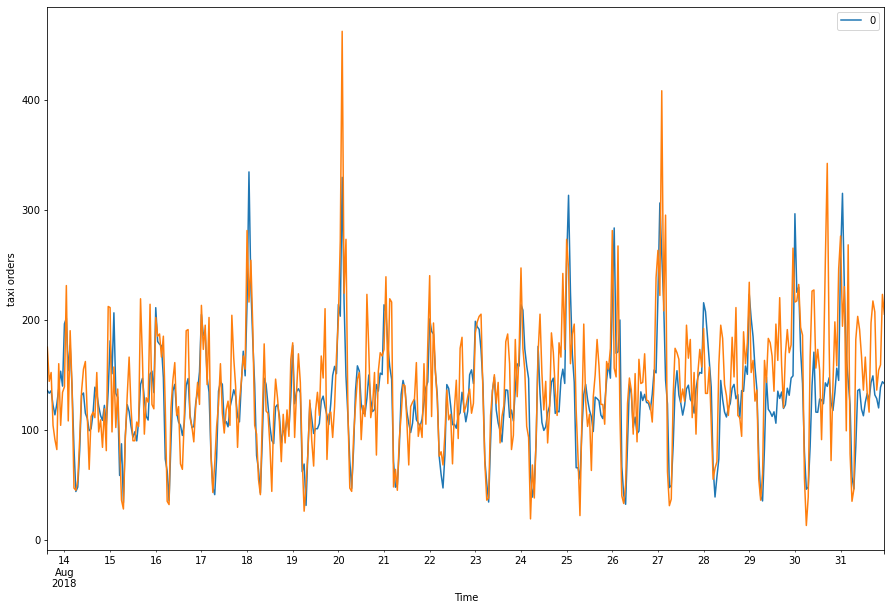

In [39]:
#изобразим предсказания при помощи модели градиентного бустинга и целевой признак
forest_prediction=pd.DataFrame(data=forest_prediction,index=test_target1.index)
plt.figure()
forest_prediction.plot()
test_target1.plot(figsize=(15,10))
plt.xlabel('Time')
plt.ylabel('taxi orders')


* Из представленного графика видно, что модель  предсказывает близкие значения , однако ошибается при "выбросах", поэтому значительно растет значение метрики RMSE.

## Вывод из цели
* Наилучшей моделью является модель случайного леса RandomForestRegressor: значение RMSE = 40.1 было достигнуто при маскимальной глубине дерева = 20 для 1-го набора данных : 5 лагов(предыдущих значений), 10 окон (для вычисления скользящего окна).

## Вывод о проделанной работе

*	Было произведено ресемплирование данных по одному часу, исходя из задачи проекта дальнейшая работа проводилась с суммой заказов за каждый час.
*	Произведен анализ данных на сезонность, тренд и сделаны выводы: сезонность отсутствует, так как данные предоставлены в период с 1 марта по 31 августа 2018 года, в период с марта по август суммарное количество заказов такси за час растет.
*	Для обучения моделей были созданы признаки: отстающие признаки, признаки скользящего среднего, календарные и временные признаки.
*	Было создана тренировочная и тестовая выборка (10% от исходных данных).
*	Обучены модели линейной регрессии, случайного леса, градиентного бустинга при помощи библиотеки CatBoostRegressor. Для каждой модели параметры подбирались методом кросс-валидации.
*	Тестирование производилось на тестовой выборке, наилучшая модель находилась при помощи метрики RMSE.
*	Наилучшей моделью является модель случайного леса RandomForestRegressor: значение RMSE = 40.1 было достигнуто при максимальной глубине дерева = 20 для 1-го набора данных: 5 лагов (предыдущих значений), 10 окон (для вычисления скользящего окна). 
*	Наилучшая модель предсказывает близкие значения, однако ошибается при "выбросах", поэтому значительно растет значение метрики RMSE.
*	Задача проекта выполнена.